In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [52]:
df = pd.read_csv('insurance.csv')
print(df.shape)
print(df.dtypes)

(381109, 12)
id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object


In [53]:
# PRE-PROCESSING

df = df.rename(columns={"Gender": "Male"})
cleanup_nums = {"Vehicle_Age": {"< 1 Year": -1, "1-2 Year": 0, "> 2 Years": 1},
                "Vehicle_Damage": {"Yes": 1, "No": 0},
                "Male": {"Male": 1, "Female": 0}}

df = df.replace(cleanup_nums)

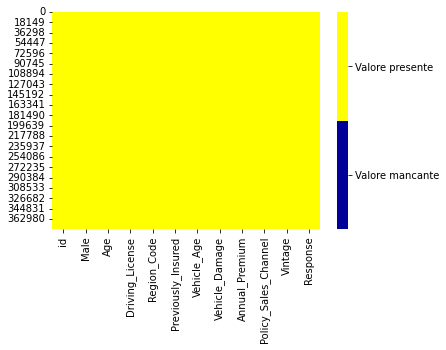

In [54]:

# HEATMAP NA
cols = df.columns[:12]  # first 30 columns
colours = ['#000099', '#ffff00']  # specify the colours - yellow is missing. blue is not missing.
ax = sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.05, 0.05])
colorbar.set_ticklabels(['Valore mancante', 'Valore presente'])
plt.show()

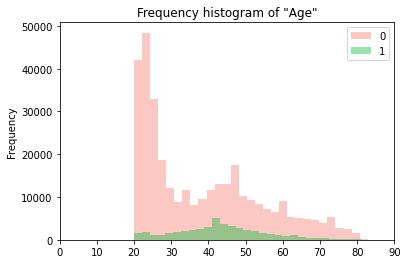

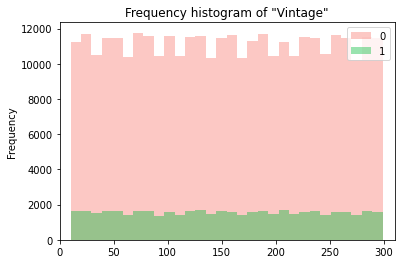

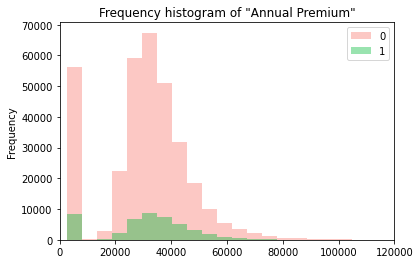

In [55]:
# FREQUENCY DISTRIBUTION PLOT
kwargs = dict(alpha=0.4, bins=30)

x1 = df.loc[df.Response == 1, 'Age']
x2 = df.loc[df.Response == 0, 'Age']

plt.hist(x2, **kwargs, color='#F8766D', label='0')
plt.hist(x1, **kwargs, color='#00BA38', label='1')
plt.gca().set(title='Frequency histogram of "Age"', ylabel='Frequency')
plt.xlim(0, 90)
plt.legend()
plt.show()

x1 = df.loc[df.Response == 1, 'Vintage']
x2 = df.loc[df.Response == 0, 'Vintage']

plt.hist(x2, **kwargs, color='#F8766D', label='0')
plt.hist(x1, **kwargs, color='#00BA38', label='1')
plt.gca().set(title='Frequency histogram of "Vintage"', ylabel='Frequency')
plt.xlim(0, 310)
plt.legend();
plt.show()

kwargs = dict(alpha=0.4, bins=100)
x1 = df.loc[df.Response == 1, 'Annual_Premium']
x2 = df.loc[df.Response == 0, 'Annual_Premium']

plt.hist(x2, **kwargs, color='#F8766D', label='0')
plt.hist(x1, **kwargs, color='#00BA38', label='1')
plt.gca().set(title='Frequency histogram of "Annual Premium"', ylabel='Frequency')
plt.xlim(0, 120000)
plt.legend()
plt.show()


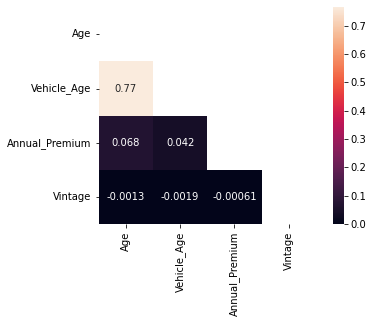

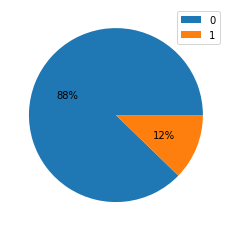

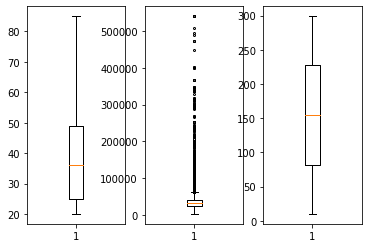

In [56]:
corMatrix = df[['Age', 'Vehicle_Age', 'Annual_Premium', 'Vintage']].corr()
Matrix = np.triu(corMatrix)
sns.heatmap(corMatrix, annot=True, square=True, mask = Matrix)
plt.show()

freq = df['Response'].value_counts(normalize=True) * 100
plt.pie(freq, autopct='%.0f%%')
plt.legend(['0', '1'])
plt.show()

plt.subplot(1, 3, 1)
plt.boxplot(df[['Age']], flierprops={'marker': 'o', 'markersize': 2})
plt.subplot(1, 3, 2)
plt.boxplot(df[['Annual_Premium']], flierprops={'markersize': 2})
plt.subplot(1, 3, 3)
plt.boxplot(df[['Vintage']], flierprops={'markersize': 2})
plt.show()

In [57]:
import sklearn as skl
import sklearn.model_selection

y = df['Response']
x = df.drop(['Response'], axis=1)
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(x, y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=1)

X_train_num = X_train.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
X_test_num = X_test.drop(['Region_Code', 'Policy_Sales_Channel'], axis=1)

<bound method BaseDecisionTree.get_depth of DecisionTreeClassifier(random_state=1)>

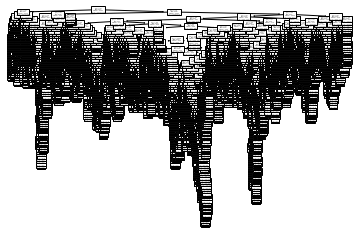

In [58]:
import sklearn.tree
decision_tree = skl.tree.DecisionTreeClassifier(random_state=1)
decision_tree = decision_tree.fit(X_train_num, y_train)
#skl.tree.plot_tree(decision_tree)
y_pred = decision_tree.predict(X_test_num)

In [66]:
def confusionMatrix (Prediction, Ground_Truth):
    from sklearn.metrics import confusion_matrix as cm
    CM = cm(Ground_Truth, Prediction)
    print(CM)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    print("Accuracy:      %f\n" %((TP+TN)/(TP + TN + FP + TN)))
    print("Sensitivity:   %f\n" %(TP/(TP+FN)))
    print("Specificity:   %f\n" %(TN/(TN+FP)))

In [60]:
confusionMatrix(y_pred, y_test)